In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

C:\Users\ajayk\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.listdir("flickr_data/Flickr_Data/Flickr_Data/Images")
#in place of "flickr_data" write ur file name which you have given while downloading

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

In [4]:
images_dir = os.listdir("Flickr_Data")

images_path = 'flickr_data/Flickr_data/Flickr_Data/Images'
captions_path = 'flickr_data/Flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = 'flickr_data/Flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = 'flickr_data/Flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = 'flickr_data/Flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [5]:
count = len(glob.glob1(images_path,"*.jpg"))
print(count)

8091


In [6]:
#understanding the format of captions for each image
file = open(captions_path, 'r')
doc = file.read()
print(doc[:300])
#each image is having 5 captions , where the index is separated with '#'followed by index

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [7]:
descriptions = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split('\t')
    # take the first token as image id, the rest as description
    image_id , image_desc  = tokens[0] , tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

In [8]:
len(descriptions)

8093

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Stemming and lemmatization

In [10]:
import string
def clean_descriptions(descriptions):
# prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [11]:
clean_descriptions(descriptions)

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [14]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [15]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    file = open(train_path, 'r')
    doc = file.read()
    dataset = list()
	# process line by line
    for line in doc.split('\n'):
# skip empty lines
        if len(line) < 1:
            continue
# get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = train_path
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [16]:
# Create a list of all image names in the directory
img = glob.glob1(images_path , '*.jpg')
len(img)

8091

In [17]:
train_images = set(open(train_path, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [18]:
print(img[1])
print(len(train_img))
print(train_img[0])

1001773457_577c3a7d70.jpg
6000
1000268201_693b08cb0e.jpg


In [19]:
test_images = set(open(test_path, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [20]:
len(test_img)

1000

In [21]:
#load descriptions of train and test set separately
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [22]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
from keras.preprocessing import image
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(os.path.join(images_path,image_path), target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [24]:
# Load the inception v3 model

from keras.applications.resnet50 import ResNet50
model = InceptionV3(weights='imagenet')

In [25]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [26]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [27]:
len(images_path)

21

In [28]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[:]] = encode(img)
print("Time Taken is: " + str(time() - start))

1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 75ms/step
Time Taken is: 695.9523510932922


In [29]:
#Encode all the test images
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[:]] = encode(img)
print("Time taken is: " + str(time() - start))

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 73ms/step
Time taken is: 118.08700203895569


In [30]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [31]:
train_features['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [32]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [33]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [34]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [35]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [36]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [37]:
#since there are almost 30000 descriptions to process we will use datagenerator
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(292328, 2048)


In [38]:
# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open('glove/glove.6B.200d.txt', encoding="utf-8")# change "glove" to name that you have given to ur file

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape

(1652, 200)

In [41]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [43]:
model.layers[2]

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
for i in range(30):
    model.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model.save_weights("image-caption-weights" + str(i) + ".h5")
        
# Depending on your free memory size our modl will fit

In [47]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [48]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [49]:
list(encoding_test.keys())[200]

'2333288869_8c01e4c859.jpg'

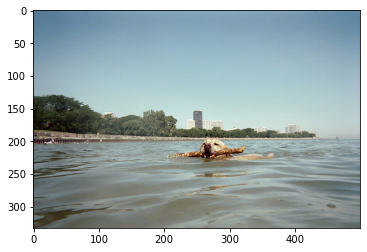

1/1 [==============================] - 0s 31ms/step
"Dog is running through the water."


In [58]:
pic = list(encoding_test.keys())[400]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images_path ,pic))
plt.imshow(x)
plt.show()
print('"'+greedy_search(img).capitalize()+'."')